# Molecular Simulation of The Lennard-Jones Disk

The task of this notebook is to simulate the Lennard-Jones potential for a two dimensional Lennard-Jones disk. This will be accomplished by using a molecular dynamic simulation, no Monte Carlo methods will be used in this process.

## Molecular Dynamical Simulations

The fundamental idea behind molecular dynamic simulations isn't too complex, if we know the initial positions of all the components that we are simulating and all the force acting on them we can predict where they will go over some fixed time period. It's a bit harder to put into code. The general idea is to split up our time period into many smaller time periods and by solving Newton's 2nd law of motion (in a second order ODE form) we can show its motion for each small 'slice' of time.
To introduce this idea lets look at a simple projectile:

### Projectile Motion under Gravity

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

fig, ax = plt.subplots(figsize=(8,8))

ax.set(xlim=(-2, 2), ylim=(0, 600), xlabel='Distance from origin, m', ylabel='Height, m', title='Falling Body')

# The initial parameters of our problem

t = 10    #seconds
m = 5  #kilograms
g = 9.81  #meters per second squared
Ux = -0.25 #meters per second
h = 575   #meters

# setting a time 'slice' to be 50 ms
dt = 0.05 #s
n = int(t / dt)

# Creating arrays to store our information
v = np.zeros((n+1, 2))
r = np.zeros((n+1, 2))
f = np.zeros((n+1, 2))

# Putting the initial conditions into the arrays:
r[0] = np.array([0, h])
v[0] = np.array([-Ux, 0])

# Representing gravity
f[:] = np.array([0, -m * g])


for i in range(n):
    v[i+1] = v[i] + f[i]/m * dt
    r[i+1] = r[i] + v[i+1] * dt


scat = ax.scatter(r[0,0], r[0,1], marker='o', c='g', s=100)

## animating the fall 
def animate(i):
    scat.set_offsets(r[i])

ani = animation.FuncAnimation(fig, func=animate, frames=n)
## this function will create a lot of .png files in a folder 'falling_body' and create an HTML page with a simulation
ani.save('fallingbody.html', writer=animation.HTMLWriter(fps= 1//dt))
plt.close()

To view the effects of our code we must import the HTML we created

In [17]:
from IPython.display import HTML
HTML(filename='fallingbody.html')


Now we just have to use the same idea to produce a Lennard-Jones simulation:

This process however will be more complex and will draw upon multiple cells to build the final product

## Lennard-Jones Disk Simulation

The structure of this simulation will be based on multiple functions and classes that are induced in the following cells, the final cell will contain all of these functions and call upon them to build the simulation.

The general structure is as follows:<br>
First the parameters of the simulation and LJ Potential are read in,<br>
Then the setup loop will initiate all coordinates, velocities, and accelerations for the 'disks',<br>
Finally the main loop will calculate the change in these values for deltaT and repeat the process over and over again untill the step limit is reached.

### Parameter Cell
These are the parameters found in the `ljdiskparam.txt` file that will be read in in the final cell

In [38]:
deltaT      = 0.005
density     = 0.8
initUcell_x = 22
initUcell_y = 22
stepAvg     = 200
stepEquil   = 0
stepLimit   = 800
temperature = 1

### Packages

In [19]:
import pandas as pd
import math
import os
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
from PIL import Image
import glob
import moviepy.editor as mp
from datetime import datetime
import time

### Functions and Objects

Here we create some functions and objects that will become useful later on. Note that the Mol class stands for molecule not the chemist's unit mole, so the self.r, .rv, and .ra stand for the position, velocity, and acceleration vectors respectively.

In [20]:
class Mol():
    def __init__(self, r, rv, ra):
        self.r = np.asarray([0.0, 0.0]) 
        self.rv = np.asarray([0.0, 0.0])
        self.ra = np.asarray([0.0, 0.0])
        
        
class Prop():
    def __init__(self, val, sum1, sum2 ):
        self.val  = val
        self.sum1 = sum1
        self.sum2 = sum2

In [21]:


def Square(x):
    return (x * x) 

def Cube(x):
    return (x * x * x)



# Randomness functions: 

def RandR():
    global randSeedP
    randSeedP = (randSeedP * IMUL + IADD) & MASK
    return (randSeedP * SCALE)

def VRand(p):
    s: float
    s  = 2 * math.pi * RandR()
    p[0] = math.cos(s)
    p[1] = math.sin(s)
    return p


# Toroidal functions:
def VWrapAll(v):
    if v[0] >= 0.5 * region[0]:
        v[0] -= region[0]
    elif v[0] < -0.5 * region[0]:
        v[0] += region[0]
        
    if v[1] >= 0.5 * region[1]:
        v[1] -= region[1]
    elif v[1] < -0.5 * region[1]:
        v[1] += region[1]        
        
    
# This function updates coordinates taking care of periodic boundaries    
def ApplyBoundaryCond():
    for n in range(nMol):
        VWrapAll(mol[n].r)

### Initialising Positions, Velocities, and Accelerations

In [22]:
def InitCoords():

    c = np.asarray([0.0, 0.0])          # Coords
    gap = np.divide(region, initUcell)
    n = 0
    for ny in range(0, int(initUcell[1])):
        for nx in range(0, int(initUcell[0])):
            
            mol[n].r = np.add(np.multiply(np.asarray([nx+0.5, ny+0.5]), gap), np.multiply(-0.5, region)) 
            n = n+1
            
            
# INITIALISE VELOCITIES.
# The initial velocities have a fixed magnitude (velMag) that depends on the temperature. After assigning random velocity directions the velocities are 
# adjusted to ensure that the center of mass is stationary. The function vRand serves as a source of uniformly distribuited random unit vectors.

def InitVels():
    
    global vSum
    vSum = np.zeros(vSum.shape)    
    
    for n in range(nMol):
        VRand(mol[n].rv)
        mol[n].rv = np.multiply(mol[n].rv, velMag)
        vSum  = np.add(vSum, mol[n].rv)


    for n in range(nMol):
        mol[n].rv = np.add(mol[n].rv, np.multiply((- 1.0 / nMol),  vSum))
        
        
# INITIALISE ACCELERATIONS.
# The accelerations are initilised to zero

def InitAccels():
    for n in range(nMol):
        mol[n].ra = np.zeros(mol[n].ra.shape)

### Setting the Parameters and the Startup Job

In [23]:
# Set parameters

def SetParams():

    global rCut
    global region
    global velMag       # velocity magnitude
    
    rCut = math.pow(2, 1/6 * sigma)

    # Define the region
    region = np.multiply( 1/math.sqrt(density), initUcell)
    nMol   = len(mol)

    #velocity magnitude depends on the temperature
    velMag = math.sqrt(NDIM * (1. -1. /nMol) * temperature)

        
# Setup Job

def SetupJob():
    
    global stepCount    #  timestep counter 

    stepCount = 0 
    InitCoords()
    InitVels()
    InitAccels()
    AccumProps(0)

### Force Computation (for each particle)

In [24]:
# This is the ComputeForces function

# ComputeForces is responsible for the interaction computations, and the interactions that occur between pairs of atoms. 
# The function implements the Lennard-Jones Potential, and calculates the accelerations and the forces for each pairs of atoms i and j located at ri and rj.

# rCut = Limiting separation cutoff (rc), and it is: rCut = math.pow(2, 1/6)
# As r increases towards rCut, the force drops to 0.
# Newton's third law inplies that Fji = -Fij, so each atom pair need only be examined once. The amount of work is proportional to N^2.


def ComputeForces():
    
    global virSum
    global uSum 
    fcVal = 0       # The force that atom j exerts on atom i
 
    rrCut = math.pow(rCut, 2)
    for n in range(nMol):
        mol[n].ra = np.zeros(mol[n].ra.shape)
    uSum = 0.
    virSum = 0.

    n = 0
    for j1 in range(nMol-1):
        for j2 in range(j1+1, nMol):
            
            # Make DeltaRij: (sum of squared RJ1-RJ2)
            dr = np.subtract(mol[j1].r, mol[j2].r)      # dr contains the delta between Rj1 and Rj2
            VWrapAll(dr)                                # toroidal function
            rr= (Square(dr[0]) + Square(dr[1]))         # dr2
            r= np.sqrt(rr)                              # dr
            
            # if dr2 < Rc^2 
            if (rr < rrCut):
                rri  = sigma / rr
                rri3 = math.pow(rri, 3)
                

                # Forces calculated with the completed Lennard-Jones.
                fcVal = 48 * epsilon * np.power(sigma, 12) / np.power(r, 13) - 24 * epsilon * np.power(sigma, 6) / np.power(r, 7) 

                # Update the accelerations multiplying force for DeltaRij
                mol[j1].ra = np.add(mol[j1].ra, np.multiply(fcVal, dr))
                mol[j2].ra = np.add(mol[j2].ra, np.multiply(-fcVal, dr))
                
                
                # The Lennard-Jones potential
                # uSum += 4. * rri3 * (rri3 - 1.) +1.
                uSum += 4 * epsilon * np.power(sigma/r, 12)/r - np.power(sigma/r, 6)              



                virSum += fcVal * rr

### Integrating the Equation of Motion

In [25]:
# This uses a simple numerical techniques: the leapfrog method. The method has useful energy conservation
# properties. LeapfrogStep integrates the coordinates and velocities. It appears twice in the function SingleStep,
# with the argument part determinating which portion of the two-step leapfrog process is to be performed:
# vx(t + h/2) = vx(t) + (h/2)ax(t)
# rx(t + h) = rx(t) + hvx (t + h/2)

def LeapfrogStep(part):
    
    if part == 1:
        for n in range(nMol): 
            mol[n].rv = np.add(mol[n].rv, np.multiply(0.5 * deltaT, mol[n].ra))
            mol[n].r  = np.add(mol[n].r, np.multiply(deltaT, mol[n].rv) )
            
    else :
        for n in range(nMol):
            mol[n].rv = np.add(mol[n].rv, np.multiply(0.5 * deltaT, mol[n].ra))

### Measuring New Properties

In [26]:
def EvalProps():
    
    global vSum
    vvSum = 0.
    vSum = np.zeros(vSum.shape)
    
    global kinEnergy
    global totEnergy
    
    
    for n in range(nMol):
        vSum=np.add(vSum, mol[n].rv)
        vv= (mol[n].rv[0] * mol[n].rv[0] + mol[n].rv[1] * mol[n].rv[1])
        vvSum += vv
        
    kinEnergy.val = (0.5 * vvSum) / nMol
    totEnergy.val = kinEnergy.val + (uSum / nMol)
    
    


def PropZero(v):
    v.sum1 = v.sum2 = 0.
    return v    
    
def PropAccum(v):
    v.sum1 += v.val
    v.sum2 += Square(v.val)
    return v    
    
def PropAvg(v, n):
    v.sum1 /= n
    v.sum2 = math.sqrt(max(v.sum2 / n - Square(v.sum1), 0.)) 
    return v    
    

# AccumProps: collects results of the measurements and evaluates the means and standard deviation

def AccumProps(key):
    
    
    if key == 0:
        PropZero(totEnergy)
        PropZero(kinEnergy) 
    if key == 1:
        PropAccum(totEnergy)
        PropAccum(kinEnergy)    
    if key == 2:
        PropAvg(totEnergy, stepAvg)
        PropAvg(kinEnergy, stepAvg) 

### Functions To Produce Visual Results

In [34]:
def plotMolCoo(mol, workdir, n):
    
    import matplotlib.patches as mpatches
    import matplotlib.pyplot as plt

    Time = timeNow
    Sigma_v = "{0:.4f}".format(vSum[0] / nMol)
    E = "{0:.4f}".format(totEnergy.sum1)
    Sigma_E = "{0:.4f}".format(totEnergy.sum2)
    Ek = "{0:.4f}".format(kinEnergy.sum1)
    Sigma_Ek = "{0:.4f}".format(kinEnergy.sum2)
    
    
    %matplotlib inline
    
    TileName = (workdir+'coo/'+str(n)+'.png')

    x = []
    y = []
    
    for n in range(len(mol)):
        x.append(mol[n].r[0])
        y.append(mol[n].r[1])
        
    mark_1 = int(len(mol)/2 + len(mol)/8)
    mark_2 = int(len(mol)/2 + len(mol)/8 + 1)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.plot(x, y, 'o', color='black') 
    ax.tick_params(grid_alpha=0)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    

    plt.title('timestep:'+"{0:.4f}".format(timeNow)+'; '+\
              '$\Sigma v$:'+Sigma_v+'; '+\
              'E:'+E+'; '+\
              '$\sigma E$:'+Sigma_E+';\n'+\
              'Ek:'+Ek+'; ' +\
              '$\sigma Ek$:'+Sigma_Ek+'; ', loc='left')
    
    plt.savefig(TileName, dpi=100)
    
    
def makeMov():
    # gif producer found online
    
    
    t = time.localtime()
    current_time = time.strftime("%D:%H:%M:%S", t)
    current_time = current_time.replace('/','-')


    # Create the frames
    frames = []
    imgs = sorted(glob.glob('coo/*.png'), key=os.path.getmtime)
    for i in imgs:
        temp = Image.open(i)
        keep = temp.copy()
        frames.append(keep)
        temp.close()
    for i in imgs:
        os.remove(i)        

    # Save into a GIF file that loops forever
    frames[0].save('coo/coordinates.gif', format='GIF',
                   append_images=frames[1:], save_all=True,
                   duration=30, loop=0)


    clip = mp.VideoFileClip("coo/coordinates.gif")
    clip.write_videofile("coo/"+"coordinates_"+current_time+".mp4")
    os.remove("coo/coordinates.gif")



def PrintSummary():

    print(stepCount, \
          "{0:.4f}".format(timeNow), \
          "{0:.4f}".format(vSum[0] / nMol) ,\
          "{0:.4f}".format(totEnergy.sum1),\
          "{0:.4f}".format(totEnergy.sum2), \
          "{0:.4f}".format(kinEnergy.sum1), \
          "{0:.4f}".format(kinEnergy.sum2))
    
    return (stepCount, \
          timeNow, \
          (vSum[0] / nMol) ,\
          totEnergy.sum1,\
          totEnergy.sum2, \
          kinEnergy.sum1, \
          kinEnergy.sum2)    


### Processing Function

In [28]:
# SingleStep is a function that handles the processing for a single timestep, 
# it does: the force evaluation, the integration of the equation of motion, 
# the adjustments required by periodic boundaries, and property measurements

def SingleStep():
    
    global stepCount        #  timestep counter
    global timeNow    

    stepCount +=1
    timeNow = stepCount * deltaT
    LeapfrogStep(1)
    ApplyBoundaryCond()
    ComputeForces()         # 1) The force evaluation
    LeapfrogStep(2)         # 2) Integration of coordinates and velocities
    EvalProps()
    AccumProps(1)           # Accumulate properties

    if (stepCount % stepAvg == 0):
        AccumProps(2)       # Calculate averages
        systemParams.append(PrintSummary())
        AccumProps(0)       # Set to zero all the properties.

### The Main Loop

200 1.0000 0.0000 2.1963 0.1161 0.6376 0.0683
400 2.0000 0.0000 2.1771 0.0166 0.6429 0.0119
600 3.0000 0.0000 2.1756 0.0285 0.6426 0.0161
800 4.0000 0.0000 2.1556 0.0206 0.6493 0.0094
Moviepy - Building video coo/coordinates_08-10-22:16:57:04.mp4.
Moviepy - Writing video coo/coordinates_08-10-22:16:57:04.mp4



Moviepy - Done !
Moviepy - video ready coo/coordinates_08-10-22:16:57:04.mp4


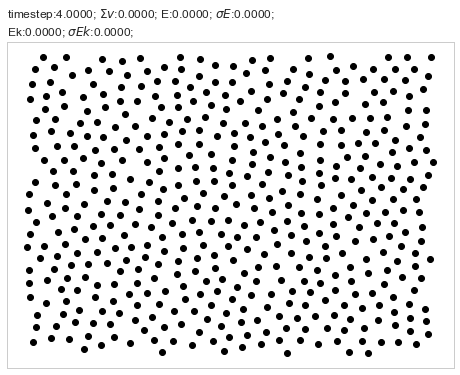

In [37]:
# Import libraries for system operations
import os.path
from os import path
import shutil


# Set a working directory for all the pngs and videos
workdir = str(os.getcwd()+'/')


# If the /coo directory doesn't exist make it, else remove
# /coo (and its contents) and create a new /coo directory.
if path.exists(str(workdir+'coo'))==False:
    os.makedirs(str(workdir+'coo'))
else:
    shutil.rmtree(str(workdir+'coo'))
    os.makedirs(str(workdir+'coo'))


# Loading in the parameter file
df_params = pd.read_csv('ljdiskparam.txt', sep='\t', header=None, names=['parameter', 'value'])

NDIM = 2                            # Two-Dimension setting
vSum = np.asarray([0.0, 0.0])       # sum of velocities
kinEnergy =Prop(0.0, 0.0, 0.0)      #Ek average
totEnergy =Prop(0.0, 0.0, 0.0)      #E average

systemParams = []

IADD = 453806245
IMUL = 314159269
MASK = 2147483647
SCALE = 0.4656612873e-9
randSeedP = 17

deltaT = float(df_params.values[0][1])
density = float(df_params.values[1][1])

initUcell = np.asarray([0.0, 0.0]) # initialize cell
initUcell[0] = int(df_params.values[2][1])
initUcell[1] = int(df_params.values[3][1])

stepAvg = int(df_params.values[4][1])
stepEquil = float(df_params.values[5][1])
stepLimit = float(df_params.values[6][1])
temperature = float(df_params.values[7][1])
float(df_params.values[7][1])

mol = [Mol(np.asarray([0.0, 0.0]), \
           np.asarray([0.0, 0.0]), \
           np.asarray([0.0, 0.0])) for i in range(int(initUcell[0]*initUcell[1]))]


# Define the number of molecules
global nMol
nMol = len(mol)

# LJ potential parameters:
epsilon =  1
sigma = 1


# Calling main loop functions
SetParams()
SetupJob()
moreCycles = 1

n = 0
while moreCycles:
    SingleStep()
    plotMolCoo(mol, workdir, n)     # Make a graph of the coordinates
    n += 1
    if stepCount >= stepLimit:
        moreCycles = 0
        

columns = ['timestep','timeNow', '$\Sigma v$', 'E', '$\sigma E$', 'Ek', '$\sigma Ek$']
df_systemParams = pd.DataFrame(systemParams, columns=columns)        

# Call function to produce the video
makeMov()

Luca Zammataro's original model was used to produce this simulation, it can be found on his towardsdatascience.com post